In [479]:
import math
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn

In [480]:
print(tf.__version__)

2.10.0


In [481]:
table = pd.read_table('./1663769555_8559356_train.txt', names=['binding','sequence'])

In [482]:
from sklearn.feature_extraction.text import CountVectorizer
def return_binary_vectorized_form(data_frame):
    count_vectorizer = CountVectorizer(binary=True)
    fitted_and_transformed = count_vectorizer.fit_transform(data_frame).toarray()
    return count_vectorizer,  fitted_and_transformed

In [483]:
from sklearn.model_selection import train_test_split
active_df = table.loc[table.binding == 1]
not_active_df = table.loc[table.binding == 0]
# Mainly spliting the data here for testing, that is the reason train size is set to .20
active_train, active_test, active_binding_train, active_binding_test = train_test_split(active_df.sequence, active_df.binding, shuffle=True, train_size= .20)
not_active_train, not_active_test, not_active_binding_train, not_active_binding_test = train_test_split(not_active_df.sequence, not_active_df.binding, shuffle=True, train_size=.90)

In [484]:
active_test_df = pd.DataFrame(active_test)
active_binding_test_df = pd.DataFrame(active_binding_test)
active_test_df['binding'] = active_binding_test_df['binding']

In [485]:
not_active_test_df = pd.DataFrame(not_active_test)
not_active_binding_test_df = pd.DataFrame(not_active_binding_test)
not_active_test_df['binding'] = not_active_binding_test_df['binding']

In [486]:
test_df = pd.concat([active_test_df,not_active_test_df]).reset_index()
test_df = test_df.drop('index',axis=1)
print(test_df.binding.value_counts())

0    73
1    63
Name: binding, dtype: int64


In [487]:
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler()
x_sampled, y_sampled = sampler.fit_resample(np.array(table.sequence).reshape(-1,1),table.binding)

In [488]:
final_train_set = pd.DataFrame(x_sampled, columns  =["sequence"])
final_train_set['binding'] = y_sampled
print(final_train_set.binding.value_counts())

final_test_set = pd.DataFrame(test_df.sequence, columns  =["sequence"])
final_test_set['binding'] = test_df.binding
print(final_test_set.binding.value_counts())

0    722
1    722
Name: binding, dtype: int64
0    73
1    63
Name: binding, dtype: int64


In [489]:
vectorizer_best, training_split = return_binary_vectorized_form(final_train_set.sequence)
test_split = vectorizer_best.transform(final_test_set.sequence).toarray()

In [490]:
print(training_split.shape)
print(test_split.shape)

(1444, 84482)
(136, 84482)


In [491]:
train_result = np.array(final_train_set.binding)
test_result = np.array(final_test_set.binding)

In [492]:
initial_weight = np.ones(training_split.shape[0])*(1/training_split.shape[0])

In [493]:
def updateWeight(missmatch, weight, alpha):
    mi = 0
    missmatch_size = len(missmatch)
    wi = 0

    new_weight = []
    norm_constant = 0
    while wi < len(weight):
        if mi < missmatch_size and missmatch[mi] == wi:
            k = weight[wi] * math.exp(alpha)
            mi+=1
        else:
            k = weight[wi] * math.exp(-1*alpha)
        new_weight.append( k )
        norm_constant += k
        wi += 1

    new_weight /= norm_constant
    sum =0
    for i in new_weight:
        sum+=i
    print(sum)
    # plt.plot(new_weight)
    # plt.show()
    return new_weight

In [494]:
from sklearn.metrics import f1_score, accuracy_score
def findMissClassificatonIndex(predicted, test_res, weight):
    error_rate = 0
    missmatch_indexes = []
    incorrect= []
    print(f1_score(test_res, predicted))
    print(accuracy_score(test_res, predicted))
    for i, (pred, real) in enumerate(zip(predicted, test_res)):
        if pred != real:
            incorrect.append((i, pred, real))
            missmatch_indexes.append(i)
            error_rate += weight[i]
    error_rate /= len(predicted)
    # print(incorrect)
    return error_rate, missmatch_indexes

In [495]:
def rejectionSampling(train_data, train_res, weights):
    samplesize  = int(2 * len(train_data))
    new_train_data = []
    new_train_res = []
    new_weights = []
    adding_index =[]
    max_w = max(weights)

    for i in range(samplesize):
        while True:
            index = random.randrange(len(weights))
            u = max_w * random.random()
            if u <= weights[index]:
                new_train_data.append(train_data[index])
                new_train_res.append(train_res[index])
                adding_index.append(index)
                break
    # print(adding_index)
    return new_train_data, new_train_res

In [496]:
from sklearn.tree import DecisionTreeClassifier

ensemble_size = 100
ensemble = []
alphas = []
def boosting(weights):

    for i in range(ensemble_size):
        train_data, train_res = rejectionSampling(training_split, train_result, weights)
        # print(sum(train_res))
        tree = DecisionTreeClassifier(max_depth= 2)
        tree.fit(train_data, train_res)
        print(sum(train_res))
        predicted_result = tree.predict(training_split)

        error_rate, error_indexes = findMissClassificatonIndex(predicted_result, train_result, weights)
        print("error_rate:", error_rate)

        if error_rate > .5:
            weights = np.ones(training_split.shape[0]) * (1/training_split.shape[0])
            print("re-balancing and training because error:", error_rate)
            continue

        amount_of_say = 0.5 * ( math.log( (1-error_rate) / error_rate ) )
        alphas.append(amount_of_say)
        ensemble.append(tree)
        weights = updateWeight(error_indexes, weights, amount_of_say)
        # Rejection Sampling0
        # plt.plot(weights)
        # plt.show()

1420
0.7630252100840336
0.8047091412742382
error_rate: 0.00013524297695689788
0.9999999999999998
2760
0.37828571428571434
0.24653739612188366
error_rate: 3.611969437809281e-07
0.9999999999999993
1051
0.7277441659464131
0.7818559556786704
error_rate: 4.4163140708805335e-07
1.0000000000000093
2767
0.3745019920318725
0.2389196675900277
error_rate: 4.7496157130897617e-07
0.9999999999999564
1001
0.7286821705426356
0.7818559556786704
error_rate: 4.4024108613599336e-07
0.9999999999999863
2754
0.3572679509632224
0.23753462603878117
error_rate: 4.750841898626267e-07
0.9999999999999921
1064
0.7352185089974292
0.78601108033241
error_rate: 4.528690120913356e-07
0.9999999999999926
2745
0.36887608069164257
0.24168975069252077
error_rate: 4.675780416392324e-07
0.9999999999999849
1058
0.7176368375325802
0.7749307479224377
error_rate: 4.5561617522412904e-07
1.0000000000000142
2716
0.3995433789954338
0.27146814404432135
error_rate: 4.5371576830397807e-07
1.0000000000000195
1091
0.7176368375325802
0.7749

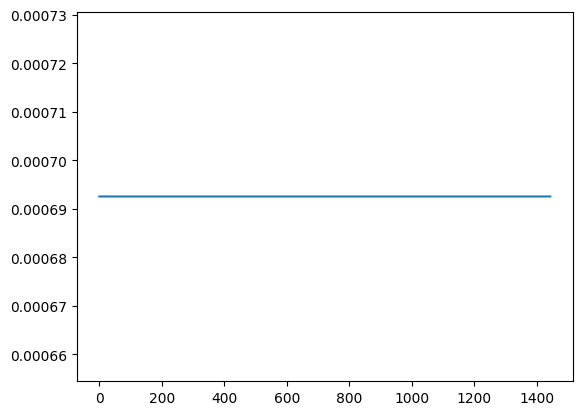

In [497]:
plt.plot(initial_weight)
boosting(initial_weight)


In [499]:
alphas

[4.454151157922161,
 7.41692105776774,
 7.31639489087885,
 7.280015731865144,
 7.317971448405795,
 7.279886665858443,
 7.3038312284696705,
 7.287849550291892,
 7.300807323630747,
 7.302897221125835,
 7.3021217724863074,
 7.279672082753096,
 7.273594781737759,
 7.295315177601897,
 6.833618036495912,
 7.286558534404953,
 7.800110243060871,
 7.286018134012776,
 7.317820508603303,
 7.275863681775009,
 6.831580028340396,
 7.278960011007524,
 7.808852073757964,
 7.2951012466222,
 7.31467293900666,
 7.27586367898612,
 7.3357977919240245,
 7.283335531044824,
 6.816584941483528,
 7.302193454402997,
 7.7191606601865494,
 7.278672597575937,
 7.280286321008861,
 7.282108986203944,
 7.3224090005272,
 7.293122980405499,
 7.3435273015354,
 7.277822565979085,
 7.506364501414134,
 7.280405448178632,
 7.327127719415159,
 7.307725762557747,
 7.275850520460751,
 7.261269858497608,
 7.2746503729948415,
 7.290962052479745,
 7.144775717321382,
 7.92121880007579,
 7.490902574639598,
 7.376442991457317,
 7.275

In [518]:
from sklearn.metrics import ConfusionMatrixDisplay
f1=[]
acc =[]
for l in range(1,40):
    data = []
    for j in range(len(test_split)):
        pa=0
        na =0
        for i in range(l):
            k = ensemble[i].predict([test_split[j]])
            if k[0] == 1:
                pa += alphas[i]
            else:
                na+=alphas[i]
        if pa >=na:
            data.append(1)
        else:
            data.append(0)
    f1.append(f1_score(test_result, data, average="macro"))
    acc.append(accuracy_score(test_result, data))

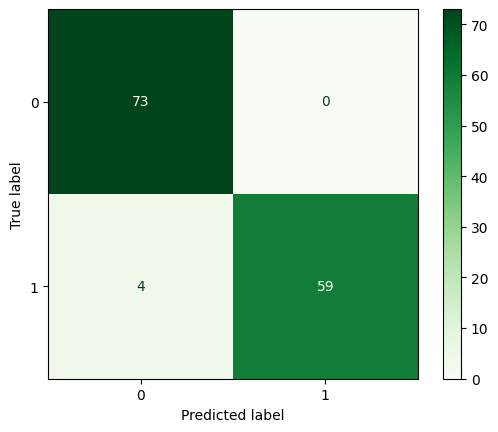

In [519]:
ConfusionMatrixDisplay.from_predictions(test_result,data,cmap='Greens')
# plt.plot(f1)


In [472]:
sum(data)

55